## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [1]:
import numpy as np 
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime

Using TensorFlow backend.


Loading up our image datasets

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/validation'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

#__this can take an hour and half to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [5]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

In [6]:
print('-'*117)

---------------------------------------------------------------------------------------------------------------------


#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

# Loading training, validation and testing data

In [11]:
datagen_top = ImageDataGenerator(rescale=1./255) 

In [12]:
#training data
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 13412 images belonging to 6 classes.


In [13]:
#validation data
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2549 images belonging to 6 classes.


In [14]:
#testing data
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 1845 images belonging to 6 classes.


# Training of model

In [15]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/Users/Iffy/anaconda3/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 13412 samples, validate on 2549 samples
Epoch 1/7
13412/13412 [==============================] - 6s 433us/step - loss: 0.7334 - acc: 0.7387 - val_loss: 0.3775 - val_acc: 0.8796
Epoch 2/7
13412/13412 [==============================] - 5s 387us/step - loss: 0.4146 - acc: 0.8575 - val_loss: 0.3253 - val_acc: 0.8921
Epoch 3/7
13412/13412 [==============================] - 5s 390us/step - loss: 0.3348 - acc: 0.8882 - val_loss: 0.3525 - val_acc: 0.8866
Epoch 4/7
13412/13412 [==============================] - 5s 392us/step - loss: 0.2845 - acc: 0.9048 - val_loss: 0.3191 - val_acc: 0.9007
Epoch 5/7
13412/13412 [==============================] - 5s 398us/step - loss: 0.2416 - acc: 0.9157 - val_loss: 0.2696 - val_acc: 0.9141
Epoch 6/7
13412/13412 [==============================] - 5s 400us/step - loss: 0.2100 - acc: 0.9291 - val_loss: 0.3327 - val_acc: 0.8964
Epoch 7/7
2549/2549 [==============================] - 0s 99us/step
[INFO] accuracy: 91.02%
[INFO] Loss: 0.2724306359638673
Time:

In [16]:
#Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2508900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306       
Total params: 2,514,256
Trainable params: 2,514,256
Non-trainable params: 0
_________________________________________________________________


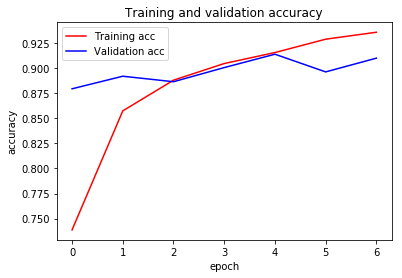

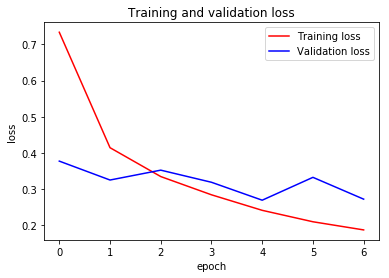

In [17]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [18]:
model.evaluate(test_data, test_labels)

1845/1845 [==============================] - 0s 184us/step


[0.2545200249690027, 0.9138211383083003]

## Testing images on model

In [19]:
def read_image(file_path, resize=True):
    image_path = file_path

    orig = mpimg.imread(image_path)  

    print("[INFO] loading and preprocessing image...")  
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  

    # important! otherwise the predictions will be '0'
    if resize:
        image = image / 255  

    image = np.expand_dims(image, axis=0)
    return image

In [20]:
path = 'data/human.jpg'

In [21]:
image_pred = read_image(path)

[INFO] loading and preprocessing image...


In [22]:
#If you have not trained your testing dataset, you may have to run it through the whole model sequence method
bottleneck_prediction = vgg16.predict(image_pred)  
class_predicted = model.predict_classes(bottleneck_prediction)

In [23]:
inID = class_predicted[0]  

class_dictionary = generator_top.class_indices  

print(class_dictionary)
print('-'*100)
inv_map = {v: k for k, v in class_dictionary.items()}  

label = inv_map[inID]  

# get the prediction label  
print("Image ID: {}, Label: {}".format(inID, label))  

{'butterflies': 0, 'chickens': 1, 'elephants': 2, 'horses': 3, 'spiders': 4, 'squirells': 5}
----------------------------------------------------------------------------------------------------
Image ID: 2, Label: elephants


<class 'PIL.Image.Image'>
<class 'numpy.ndarray'>
(224, 224, 3)


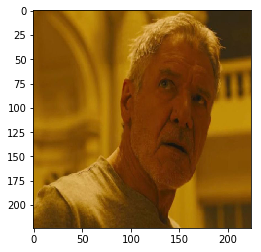

In [24]:
img_path = path
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))

x = image.img_to_array(img)
print(type(x))
print(x.shape)
plt.imshow(x/255.)